In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from scipy.stats import pearsonr

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision.transforms as transforms
from torchvision.models import vgg16
from PIL import Image

from facenet_pytorch import MTCNN, InceptionResnetV1

import warnings

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("../data/data.csv")
del data["Unnamed: 0"]
data.shape

(4206, 4)

In [3]:
data.head()

,bmi,gender,is_training,name
0,34.207396,Male,1,img_0.bmp
1,26.453720,Male,1,img_1.bmp
2,34.967561,Female,1,img_2.bmp
3,22.044766,Female,1,img_3.bmp
4,37.758789,Female,1,img_4.bmp


In [4]:
drop_index = []
for i in tqdm(range(len(data))):
    p = f"../data/Images/{data.name[i]}"
    if not os.path.exists(p):
        drop_index.append(i)

data = data.drop(index=drop_index)
data.reset_index(drop=True, inplace=True)
data.shape

  0%|          | 0/4206 [00:00<?, ?it/s]

(3962, 4)

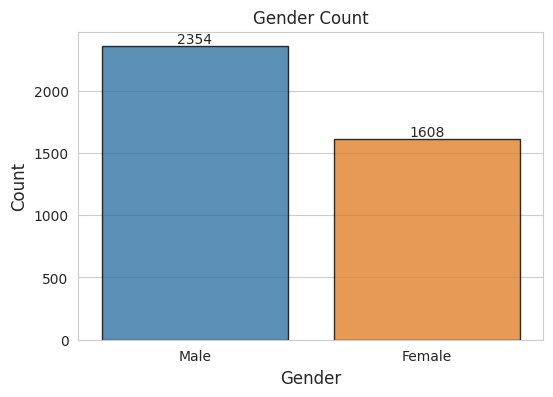

In [9]:
gender_count = data.gender.value_counts().sort_values(ascending=False)

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=gender_count.index, y=gender_count.values, alpha=0.8, edgecolor="k")
ax.bar_label(ax.containers[0])

plt.title('Gender Count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

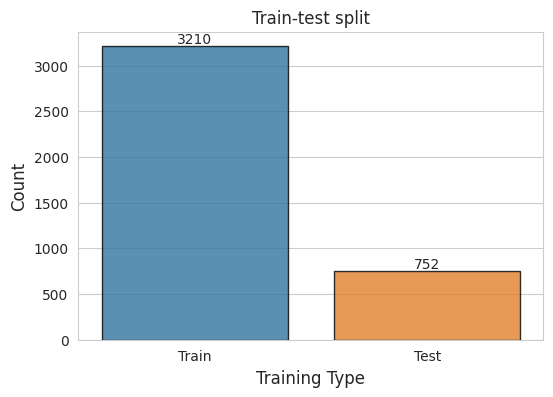

In [8]:
train_test_count = data.is_training.value_counts().sort_values(ascending=False)

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=["Train", "Test"], y=train_test_count.values, alpha=0.8, edgecolor='k')
ax.bar_label(ax.containers[0])

plt.title('Train-test split')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Training Type', fontsize=12)
plt.show()

In [7]:
data2 = pd.read_csv("../data/augmented-data.csv")
data2.shape

(5763, 3)

In [8]:
drop_index = []
for i in tqdm(range(len(data2))):
    p = f"../data/Augmented-Images/{data2.name[i]}"
    if not os.path.exists(p):
        drop_index.append(i)

data2 = data2.drop(index=drop_index)
data2.reset_index(drop=True, inplace=True)
data2.shape

  0%|          | 0/5763 [00:00<?, ?it/s]

(5672, 3)

In [9]:
data2.head()

,bmi,is_training,name
0,19.366391,1,img_161.bmp
1,19.575629,1,img_267.bmp
2,17.718967,1,img_287.bmp
3,19.909180,1,img_423.bmp
4,19.966864,1,img_727.bmp


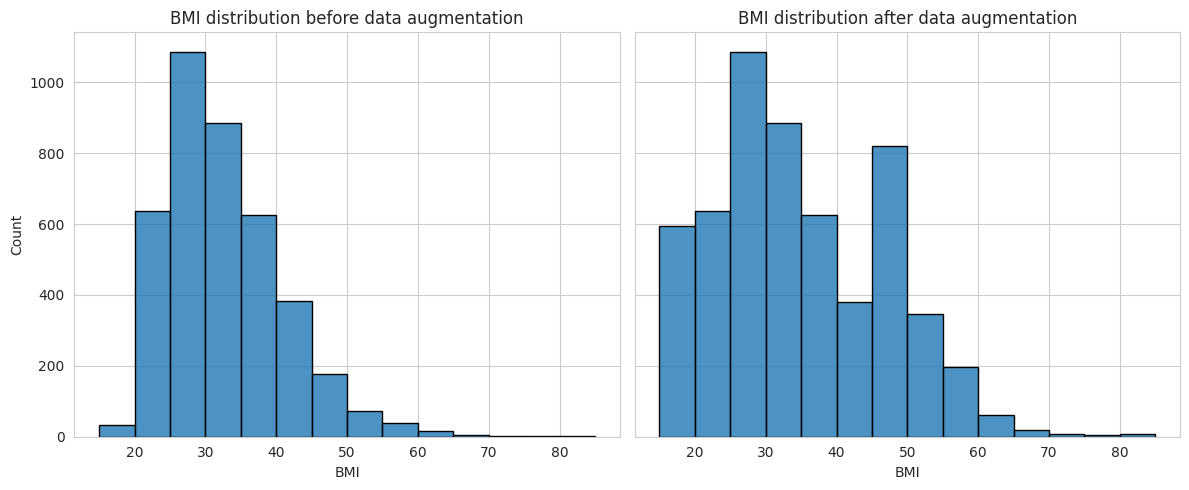

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

ax = sns.histplot(data=data.bmi.values, bins=np.arange(15, 90, 5), alpha=0.8, ax=axes[0], edgecolor="k")
ax = sns.histplot(data=data2.bmi.values, bins=np.arange(15, 90, 5), alpha=0.8, ax=axes[1], edgecolor="k")

axes[0].set_title("BMI distribution before data augmentation")
axes[1].set_title("BMI distribution after data augmentation")

axes[0].set_xlabel("BMI")
axes[0].set_ylabel("Count")

axes[1].set_xlabel("BMI")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

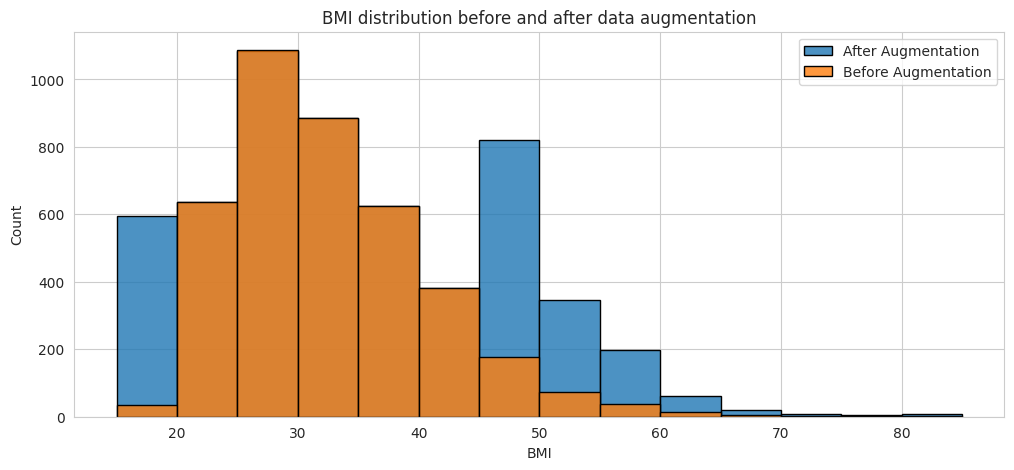

In [11]:
plt.figure(figsize=(12, 5))

sns.histplot(data=data2.bmi.values, bins=np.arange(15, 90, 5), alpha=0.8, edgecolor="k", label="After Augmentation")
sns.histplot(data=data.bmi.values, bins=np.arange(15, 90, 5), alpha=0.8, edgecolor="k", label="Before Augmentation")

plt.title("BMI distribution before and after data augmentation")

plt.xlabel("BMI")
plt.ylabel("Count")

plt.legend()

plt.show()

In [12]:
data.bmi.mean().round(2), data.bmi.median().round(2), data.bmi.std().round(2)

(32.67, 31.17, 8.27)

In [45]:
img_paths, y, train_test = [], [], []
for i in tqdm(range(len(data2))):
    p = f"../data/Augmented-Images/{data2.name[i]}"
    img_paths.append(p)
    y.append(data2.bmi[i])
    train_test.append(data2.is_training[i])

y = np.array(y)
len(img_paths), len(y), len(train_test)

  0%|          | 0/5672 [00:00<?, ?it/s]

(5672, 5672, 5672)

In [46]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [47]:
data_type = "augmented"

if data_type == "augmented":
    data = data2.copy()

data.shape

(5672, 3)

In [77]:
embeddings = "casia-webface" # vggface2, casia-webface

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(
    image_size=160, margin=40, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained=embeddings).eval().to(device)

In [78]:
# save_path = "aug_data_vggface2_embeddings.npy"
save_path = f"{data_type}_data_{embeddings}_embeddings.npy"

# Define the transformation to preprocess the images
preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def extract_features(img):
    img = img.convert('RGB')
    face = mtcnn(img)
    if face is None:
        face = preprocess(img)
    
    img = torch.stack([face]).to(device)
    
    with torch.no_grad():
        features = resnet(img)
    
    return features[0].cpu().numpy() # .squeeze()

if os.path.exists(f"../data/{save_path}"):
    X = np.load(f"../data/{save_path}")
else:
    # Extract features for each image
    X = []
    for image_path in tqdm(img_paths):
        img = Image.open(image_path)
        features = extract_features(img)
        X.append(features)

    # Convert the features to a NumPy array
    X = np.array(X)
    # X = X[:, 0, :]
    np.save(f"../data/{save_path}", X)

X.shape

  0%|          | 0/5672 [00:00<?, ?it/s]

(5672, 512)

In [79]:
X_train, X_test, y_train, y_test = [], [], [], []
for i in tqdm(range(len(train_test))):
    if train_test[i]:
        X_train.append(X[i, :])
        y_train.append(y[i])
    else:
        X_test.append(X[i, :])
        y_test.append(y[i])

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train.shape, X_test.shape

  0%|          | 0/5672 [00:00<?, ?it/s]

((4925, 512), (747, 512))

In [106]:
res_path = "../data/results.csv"
if os.path.exists(res_path):
    results_df = pd.read_csv(res_path, keep_default_na=False)
else:
    results_df = pd.DataFrame(
        columns=["Dataset Type", "Embeddings", "Regression Model", "RMSE", "MAE", "Pearson R", "Best Hyperparameters"]
    )

def update_res_df(results_df, best_params=None):
    index = len(results_df)
    results_df.loc[index, "Dataset Type"] = data_type.capitalize()
    results_df.loc[index, "Embeddings"] = embeddings
    results_df.loc[index, "Regression Model"] = reg_model
    results_df.loc[index, "RMSE"] = rmse
    results_df.loc[index, "MAE"] = mae
    results_df.loc[index, "Pearson R"] = pearson_r
    if best_params is None:
        best_params = str(grid_search.best_params_)
    results_df.loc[index, "Best Hyperparameters"] = best_params
    
    return results_df

In [108]:
results_df

,Dataset Type,Embeddings,Regression Model,RMSE,MAE,Pearson R,Best Hyperparameters
0,Original,vggface2,Random Forest,7.34,5.30,0.63,"{'max_depth': None, 'n_estimators': 200}"
1,Original,vggface2,XGBoost,7.28,5.25,0.62,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
2,Original,vggface2,SVM,7.23,5.15,0.64,"{'C': 5, 'epsilon': 0.2, 'kernel': 'rbf'}"
3,Original,vggface2,NN,7.92,5.69,0.55,"{'num_layers': 5, 'dropout': 0.3}"
4,Original,vggface2,Linear Regression,7.11,5.20,0.64,
5,Original,casia-webface,Random Forest,7.49,5.42,0.61,"{'max_depth': None, 'n_estimators': 200}"
6,Original,casia-webface,XGBoost,7.41,5.25,0.60,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
7,Original,casia-webface,SVM,7.19,5.07,0.65,"{'C': 5, 'epsilon': 0.2, 'kernel': 'rbf'}"
8,Original,casia-webface,NN,8.21,5.94,0.52,"{'num_layers': 5, 'dropout': 0.3}"
9,Original,casia-webface,Linear Regression,7.24,5.36,0.63,


### --- RF ---

In [82]:
reg_model = "Random Forest"

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}

rf = RandomForestRegressor(random_state=42, n_jobs=18)
scoring = make_scorer(mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(rf, param_grid, scoring=scoring, cv=5, n_jobs=18, verbose=10)
grid_search.fit(X_train, y_train)

tr_pred = grid_search.best_estimator_.predict(X_train)
ts_pred = grid_search.best_estimator_.predict(X_test)

pearson_r = round(pearsonr(y_test, ts_pred)[0], 2)
rmse = round(mean_squared_error(y_test, ts_pred, squared=False), 2)
mae = round(mean_absolute_error(y_test, ts_pred), 2)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [83]:
print("--- Train ---")
print("Pearson R:", round(pearsonr(y_train, tr_pred)[0], 2))
print("RMSE     :", round(mean_squared_error(y_train, tr_pred, squared=False), 2))
print("MAE      :", round(mean_absolute_error(y_train, tr_pred), 2))

print("\n--- Test ---")
print("Pearson R:", pearson_r)
print("RMSE     :", rmse)
print("MAE      :", mae)

--- Train ---
Pearson R: 0.99
RMSE     : 2.62
MAE      : 2.02

--- Test ---
Pearson R: 0.61
RMSE     : 7.32
MAE      : 5.48


In [84]:
with open(f"../models/rf_{data_type}_{embeddings}.p", "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)

In [85]:
results_df = update_res_df(results_df)
results_df

,Dataset Type,Embeddings,Regression Model,RMSE,MAE,Pearson R,Best Hyperparameters
0,Original,vggface2,Random Forest,7.34,5.30,0.63,"{'max_depth': None, 'n_estimators': 200}"
1,Original,vggface2,XGBoost,7.28,5.25,0.62,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
2,Original,vggface2,SVM,7.23,5.15,0.64,"{'C': 5, 'epsilon': 0.2, 'kernel': 'rbf'}"
3,Original,vggface2,NN,7.92,5.69,0.55,"{'num_layers': 5, 'dropout': 0.3}"
4,Original,vggface2,Linear Regression,7.11,5.20,0.64,NaN
5,Original,casia-webface,Random Forest,7.49,5.42,0.61,"{'max_depth': None, 'n_estimators': 200}"
6,Original,casia-webface,XGBoost,7.41,5.25,0.60,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
7,Original,casia-webface,SVM,7.19,5.07,0.65,"{'C': 5, 'epsilon': 0.2, 'kernel': 'rbf'}"
8,Original,casia-webface,NN,8.21,5.94,0.52,"{'num_layers': 5, 'dropout': 0.3}"
9,Original,casia-webface,Linear Regression,7.24,5.36,0.63,NaN


## --- XGBoost ---

In [86]:
reg_model = "XGBoost"

param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5],
    'n_estimators': [50, 100]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
scoring = make_scorer(mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(xgb, param_grid, scoring=scoring, cv=5, n_jobs=18, verbose=1)
grid_search.fit(X_train, y_train)

tr_pred = grid_search.best_estimator_.predict(X_train)
ts_pred = grid_search.best_estimator_.predict(X_test)

pearson_r = round(pearsonr(y_test, ts_pred)[0], 2)
rmse = round(mean_squared_error(y_test, ts_pred, squared=False), 2)
mae = round(mean_absolute_error(y_test, ts_pred), 2)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [87]:
print("--- Train ---")
print("Pearson R:", round(pearsonr(y_train, tr_pred)[0], 2))
print("RMSE     :", round(mean_squared_error(y_train, tr_pred, squared=False), 2))
print("MAE      :", round(mean_absolute_error(y_train, tr_pred), 2))

print("\n--- Test ---")
print("Pearson R:", pearson_r)
print("RMSE     :", rmse)
print("MAE      :", mae)

--- Train ---
Pearson R: 0.96
RMSE     : 3.5
MAE      : 2.72

--- Test ---
Pearson R: 0.6
RMSE     : 7.41
MAE      : 5.52


In [88]:
with open(f"../models/xgb_{data_type}_{embeddings}.p", "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)

In [89]:
results_df = update_res_df(results_df)
results_df

,Dataset Type,Embeddings,Regression Model,RMSE,MAE,Pearson R,Best Hyperparameters
0,Original,vggface2,Random Forest,7.34,5.30,0.63,"{'max_depth': None, 'n_estimators': 200}"
1,Original,vggface2,XGBoost,7.28,5.25,0.62,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
2,Original,vggface2,SVM,7.23,5.15,0.64,"{'C': 5, 'epsilon': 0.2, 'kernel': 'rbf'}"
3,Original,vggface2,NN,7.92,5.69,0.55,"{'num_layers': 5, 'dropout': 0.3}"
4,Original,vggface2,Linear Regression,7.11,5.20,0.64,NaN
5,Original,casia-webface,Random Forest,7.49,5.42,0.61,"{'max_depth': None, 'n_estimators': 200}"
6,Original,casia-webface,XGBoost,7.41,5.25,0.60,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
7,Original,casia-webface,SVM,7.19,5.07,0.65,"{'C': 5, 'epsilon': 0.2, 'kernel': 'rbf'}"
8,Original,casia-webface,NN,8.21,5.94,0.52,"{'num_layers': 5, 'dropout': 0.3}"
9,Original,casia-webface,Linear Regression,7.24,5.36,0.63,NaN


### --- SVM ---

In [90]:
reg_model = "SVM"

param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 5, 10, 15],
    'epsilon': [0.01, 0.05, 0.1, 0.2],
}

svm = SVR()
scoring = make_scorer(mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(svm, param_grid, scoring=scoring, cv=5, n_jobs=14, verbose=10)
grid_search.fit(X_train, y_train)

tr_pred = grid_search.predict(X_train)
ts_pred = grid_search.predict(X_test)

pearson_r = round(pearsonr(y_test, ts_pred)[0], 2)
rmse = round(mean_squared_error(y_test, ts_pred, squared=False), 2)
mae = round(mean_absolute_error(y_test, ts_pred), 2)

[CV 1/5; 1/9] START max_depth=None, n_estimators=50.............................
[CV 1/5; 1/9] END max_depth=None, n_estimators=50;, score=-147.220 total time= 1.0min
[CV 1/5; 6/9] START max_depth=5, n_estimators=200...............................
[CV 1/5; 6/9] END max_depth=5, n_estimators=200;, score=-160.776 total time= 1.8min
[CV 4/5; 9/9] START max_depth=10, n_estimators=200..............................
[CV 4/5; 9/9] END max_depth=10, n_estimators=200;, score=-64.043 total time= 1.4min
[CV 3/5; 4/9] START max_depth=5, n_estimators=50................................
[CV 3/5; 4/9] END max_depth=5, n_estimators=50;, score=-43.819 total time=  30.4s
[CV 1/5; 5/9] START max_depth=5, n_estimators=100...............................
[CV 1/5; 5/9] END max_depth=5, n_estimators=100;, score=-161.588 total time=  56.9s
[CV 4/5; 6/9] START max_depth=5, n_estimators=200...............................
[CV 4/5; 6/9] END max_depth=5, n_estimators=200;, score=-87.230 total time= 1.8min
[CV 2/5; 3/

In [91]:
print("--- Train ---")
print("Pearson R:", round(pearsonr(y_train, tr_pred)[0], 2))
print("RMSE     :", round(mean_squared_error(y_train, tr_pred, squared=False), 2))
print("MAE      :", round(mean_absolute_error(y_train, tr_pred), 2))

print("\n--- Test ---")
print("Pearson R:", pearson_r)
print("RMSE     :", rmse)
print("MAE      :", mae)

--- Train ---
Pearson R: 0.99
RMSE     : 1.29
MAE      : 0.48

--- Test ---
Pearson R: 0.6
RMSE     : 7.37
MAE      : 5.43


In [92]:
with open(f"../models/svm_{data_type}_{embeddings}.p", "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)

In [93]:
results_df = update_res_df(results_df)
results_df

,Dataset Type,Embeddings,Regression Model,RMSE,MAE,Pearson R,Best Hyperparameters
0,Original,vggface2,Random Forest,7.34,5.30,0.63,"{'max_depth': None, 'n_estimators': 200}"
1,Original,vggface2,XGBoost,7.28,5.25,0.62,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
2,Original,vggface2,SVM,7.23,5.15,0.64,"{'C': 5, 'epsilon': 0.2, 'kernel': 'rbf'}"
3,Original,vggface2,NN,7.92,5.69,0.55,"{'num_layers': 5, 'dropout': 0.3}"
4,Original,vggface2,Linear Regression,7.11,5.20,0.64,NaN
5,Original,casia-webface,Random Forest,7.49,5.42,0.61,"{'max_depth': None, 'n_estimators': 200}"
6,Original,casia-webface,XGBoost,7.41,5.25,0.60,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
7,Original,casia-webface,SVM,7.19,5.07,0.65,"{'C': 5, 'epsilon': 0.2, 'kernel': 'rbf'}"
8,Original,casia-webface,NN,8.21,5.94,0.52,"{'num_layers': 5, 'dropout': 0.3}"
9,Original,casia-webface,Linear Regression,7.24,5.36,0.63,NaN


### --- NN ---

In [94]:
reg_model = "NN"

import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        x = torch.relu(x)
        x = self.fc5(x)
        x = torch.relu(x)
        return x


# Early stopping parameters
patience = 20
best_val_loss = float('inf')
best_model_state_dict = None
epochs_without_improvement = 0

# Create an instance of the network
model = Net()

# Define the loss function
criterion = nn.L1Loss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)

X_train1, X_test1 = torch.Tensor(X_train), torch.Tensor(X_test)
y_train1, y_test1 = torch.Tensor(y_train), torch.Tensor(y_test)

# Training loop
num_epochs = 500
batch_size = 32

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(0, len(X_train1), batch_size):
        inputs = X_train1[i:i+batch_size]
        labels = y_train1[i:i+batch_size]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Compute the validation loss
    val_outputs = model(X_test1)
    val_loss = criterion(val_outputs.squeeze(), y_test1)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}, Validation Loss: {val_loss}")
    
    # Check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement == patience:
            print("Early stopping! Validation loss did not improve for {} epochs.".format(patience))
            break

model.load_state_dict(best_model_state_dict)

# Make predictions
tr_pred = model(X_train1).squeeze().detach().numpy()
ts_pred = model(X_test1).squeeze().detach().numpy()

pearson_r = round(pearsonr(y_test, ts_pred)[0], 2)
rmse = round(mean_squared_error(y_test, ts_pred, squared=False), 2)
mae = round(mean_absolute_error(y_test, ts_pred), 2)

Epoch 1/500, Loss: 5420.700651168823, Validation Loss: 33.54462432861328
Epoch 2/500, Loss: 5416.385025024414, Validation Loss: 33.51012420654297
Epoch 3/500, Loss: 5409.319229125977, Validation Loss: 33.45270538330078
Epoch 4/500, Loss: 5398.5557498931885, Validation Loss: 33.36233901977539
Epoch 5/500, Loss: 5376.148738861084, Validation Loss: 33.13661193847656
Epoch 6/500, Loss: 5321.215795516968, Validation Loss: 32.61199951171875
Epoch 7/500, Loss: 5206.130723953247, Validation Loss: 31.567609786987305
Epoch 8/500, Loss: 4987.018474578857, Validation Loss: 29.675823211669922
Epoch 9/500, Loss: 4605.31635761261, Validation Loss: 26.491348266601562
Epoch 10/500, Loss: 3999.9616804122925, Validation Loss: 21.663606643676758
Epoch 11/500, Loss: 3106.0713863372803, Validation Loss: 14.775585174560547
Epoch 12/500, Loss: 2009.5516166687012, Validation Loss: 8.565516471862793
Epoch 13/500, Loss: 1395.5562953948975, Validation Loss: 7.554800033569336
Epoch 14/500, Loss: 1317.4143424034119

Epoch 111/500, Loss: 1052.6300966739655, Validation Loss: 6.984341144561768
Epoch 112/500, Loss: 1043.1828169822693, Validation Loss: 7.044688701629639
Epoch 113/500, Loss: 1052.178139448166, Validation Loss: 7.099557876586914
Epoch 114/500, Loss: 1038.4928414821625, Validation Loss: 6.9890828132629395
Epoch 115/500, Loss: 1045.46044588089, Validation Loss: 7.105500221252441
Epoch 116/500, Loss: 1041.4381363391876, Validation Loss: 7.0521159172058105
Epoch 117/500, Loss: 1038.4910588264465, Validation Loss: 6.93174409866333
Epoch 118/500, Loss: 1041.933956861496, Validation Loss: 7.078704357147217
Epoch 119/500, Loss: 1039.787836074829, Validation Loss: 7.021984577178955
Epoch 120/500, Loss: 1044.1411418914795, Validation Loss: 7.0710601806640625
Epoch 121/500, Loss: 1043.8200416564941, Validation Loss: 7.026226043701172
Epoch 122/500, Loss: 1037.222540140152, Validation Loss: 7.0337090492248535
Epoch 123/500, Loss: 1029.1724934577942, Validation Loss: 7.037125110626221
Epoch 124/500, 

In [95]:
print("--- Train ---")
print("Pearson R:", round(pearsonr(y_train, tr_pred)[0], 2))
print("RMSE     :", round(mean_squared_error(y_train, tr_pred, squared=False), 2))
print("MAE      :", round(mean_absolute_error(y_train, tr_pred), 2))

print("\n--- Test ---")
print("Pearson R:", pearson_r)
print("RMSE     :", rmse)
print("MAE      :", mae)

--- Train ---
Pearson R: 0.72
RMSE     : 8.59
MAE      : 6.54

--- Test ---
Pearson R: 0.56
RMSE     : 8.78
MAE      : 6.76


In [96]:
with open(f"../models/nn_{data_type}_{embeddings}.p", "wb") as f:
    pickle.dump(model, f)

In [97]:
results_df = update_res_df(results_df, best_params=str({"num_layers": 5, "dropout": 0.3}))
results_df

,Dataset Type,Embeddings,Regression Model,RMSE,MAE,Pearson R,Best Hyperparameters
0,Original,vggface2,Random Forest,7.34,5.30,0.63,"{'max_depth': None, 'n_estimators': 200}"
1,Original,vggface2,XGBoost,7.28,5.25,0.62,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
2,Original,vggface2,SVM,7.23,5.15,0.64,"{'C': 5, 'epsilon': 0.2, 'kernel': 'rbf'}"
3,Original,vggface2,NN,7.92,5.69,0.55,"{'num_layers': 5, 'dropout': 0.3}"
4,Original,vggface2,Linear Regression,7.11,5.20,0.64,NaN
5,Original,casia-webface,Random Forest,7.49,5.42,0.61,"{'max_depth': None, 'n_estimators': 200}"
6,Original,casia-webface,XGBoost,7.41,5.25,0.60,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
7,Original,casia-webface,SVM,7.19,5.07,0.65,"{'C': 5, 'epsilon': 0.2, 'kernel': 'rbf'}"
8,Original,casia-webface,NN,8.21,5.94,0.52,"{'num_layers': 5, 'dropout': 0.3}"
9,Original,casia-webface,Linear Regression,7.24,5.36,0.63,NaN


### --- LR ---

In [98]:
reg_model = "Linear Regression"

from sklearn.linear_model import LinearRegression

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

tr_pred = model.predict(X_train)
ts_pred = model.predict(X_test)

pearson_r = round(pearsonr(y_test, ts_pred)[0], 2)
rmse = round(mean_squared_error(y_test, ts_pred, squared=False), 2)
mae = round(mean_absolute_error(y_test, ts_pred), 2)

In [99]:
print("--- Train ---")
print("Pearson R:", round(pearsonr(y_train, tr_pred)[0], 2))
print("RMSE     :", round(mean_squared_error(y_train, tr_pred, squared=False), 2))
print("MAE      :", round(mean_absolute_error(y_train, tr_pred), 2))

print("\n--- Test ---")
print("Pearson R:", pearson_r)
print("RMSE     :", rmse)
print("MAE      :", mae)

--- Train ---
Pearson R: 0.84
RMSE     : 6.5
MAE      : 5.05

--- Test ---
Pearson R: 0.6
RMSE     : 7.74
MAE      : 5.93


In [100]:
with open(f"../models/lr_{data_type}_{embeddings}.p", "wb") as f:
    pickle.dump(model, f)

In [101]:
results_df = update_res_df(results_df, best_params="N/A")
results_df

,Dataset Type,Embeddings,Regression Model,RMSE,MAE,Pearson R,Best Hyperparameters
0,Original,vggface2,Random Forest,7.34,5.30,0.63,"{'max_depth': None, 'n_estimators': 200}"
1,Original,vggface2,XGBoost,7.28,5.25,0.62,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
2,Original,vggface2,SVM,7.23,5.15,0.64,"{'C': 5, 'epsilon': 0.2, 'kernel': 'rbf'}"
3,Original,vggface2,NN,7.92,5.69,0.55,"{'num_layers': 5, 'dropout': 0.3}"
4,Original,vggface2,Linear Regression,7.11,5.20,0.64,NaN
5,Original,casia-webface,Random Forest,7.49,5.42,0.61,"{'max_depth': None, 'n_estimators': 200}"
6,Original,casia-webface,XGBoost,7.41,5.25,0.60,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
7,Original,casia-webface,SVM,7.19,5.07,0.65,"{'C': 5, 'epsilon': 0.2, 'kernel': 'rbf'}"
8,Original,casia-webface,NN,8.21,5.94,0.52,"{'num_layers': 5, 'dropout': 0.3}"
9,Original,casia-webface,Linear Regression,7.24,5.36,0.63,NaN


In [102]:
results_df.to_csv(res_path, index=False)